In [1]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Import internal modules (project-specific)
import config
from config import MODEL_NAMES, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor


# Add src directory to Python path
src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [3]:
df = preprocessor.load_data(config.DATASET_PATH)

display("shape:", df.shape)
display("columns:", df.columns)
display(df.head())
display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient has a known history of hypertension. P...,Patient expresses fear and anxiety about high ...,NaN
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Patient is hopeful and shows no significant an...,NaN
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Elderly patient expresses fear of declining he...,NaN
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,No ongoing chronic conditions noted. General c...,Patient (minor) is anxious and fearful about m...,NaN
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,Patient has a known history of hypertension. P...,Patient experiences stress and anxiety managin...,NaN


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [4]:
df = preprocessor.preprocess_data(df)

# Display the information, first few rows, and descriptive statistics of the DataFrame
display("shape:", df.shape)
display("columns:", df.columns)
display(df.head())
display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the datas

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient has a known history of hypertension. P...,Patient expresses fear and anxiety about high ...,NaN,-1,1,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,No ongoing chronic conditions noted. General c...,Patient is hopeful and shows no significant an...,NaN,-1,1,1,0,1,1
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,No ongoing chronic conditions noted. General c...,Elderly patient expresses fear of declining he...,NaN,-1,0,1,1,0,1
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,No ongoing chronic conditions noted. General c...,Patient (minor) is anxious and fearful about m...,NaN,-1,0,1,0,0,1
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,Patient has a known history of hypertension. P...,Patient experiences stress and anxiety managin...,NaN,-1,1,1,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.674179,0.936287,0.191564,0.446045,0.980674
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.468683,0.244242,0.393534,0.497083,0.137667
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis on the patient appointments dataset to understand the data, visualize key features, and derive insights.

## Visualizations

Visualize the distribution of key features and their relationships.

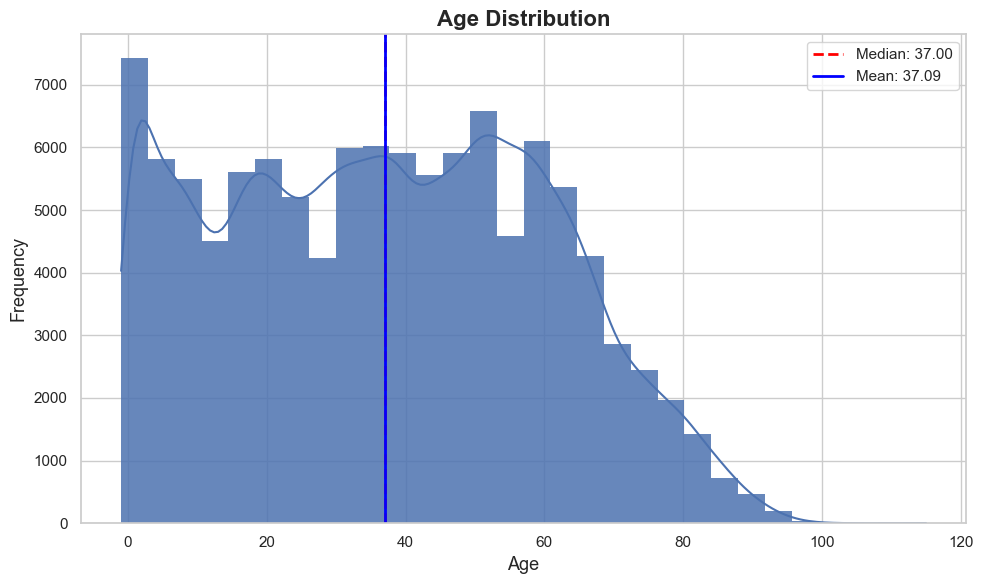

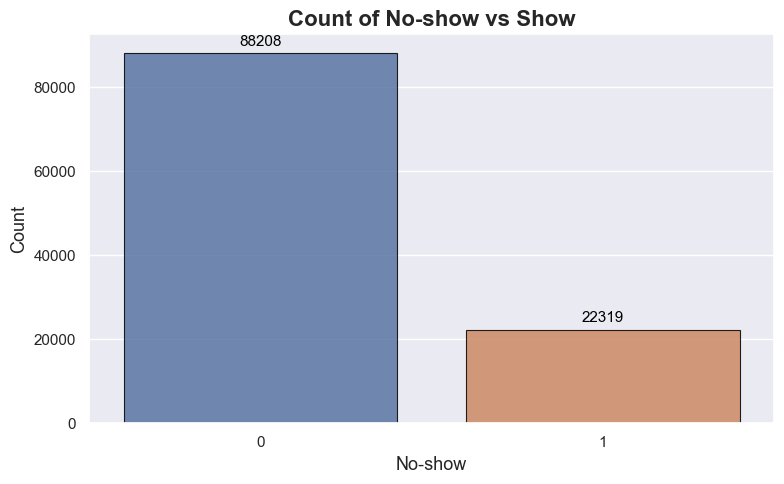

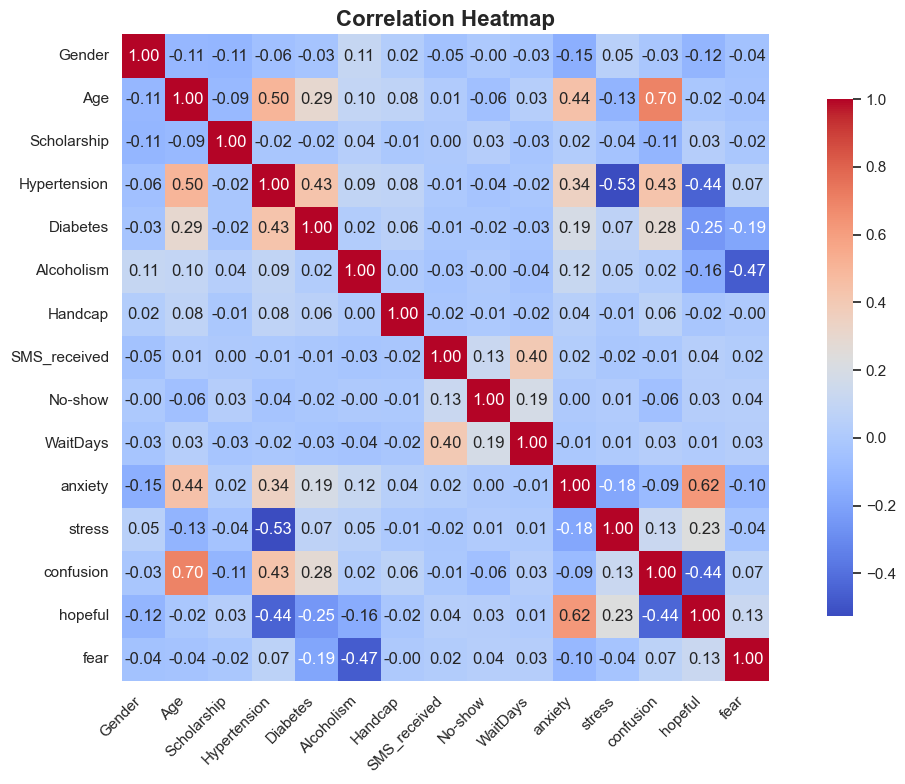

In [5]:
# Distribution of Age - Using class-based approach
plotter.plot_histplot(
    data=df,
    column='Age',
    bins=30,
    kde=True,
    title='Age Distribution',
    xlabel='Age',
    ylabel='Frequency',
    figsize=(10, 6)
)

# Countplot of No-show vs Show
plotter.plot_countplot(
    data=df,
    column='No-show',
    title='Count of No-show vs Show',
    xlabel='No-show',
    ylabel='Count',
    figsize=(8, 5)
)

# Correlation heatmap 
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plotter.plot_heatmap(
    data=correlation_matrix,
    title='Correlation Heatmap',
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    figsize=(12, 8)
)

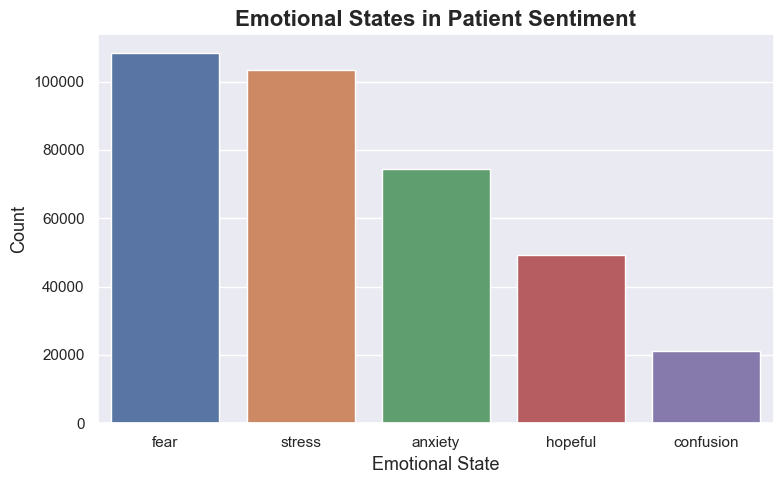

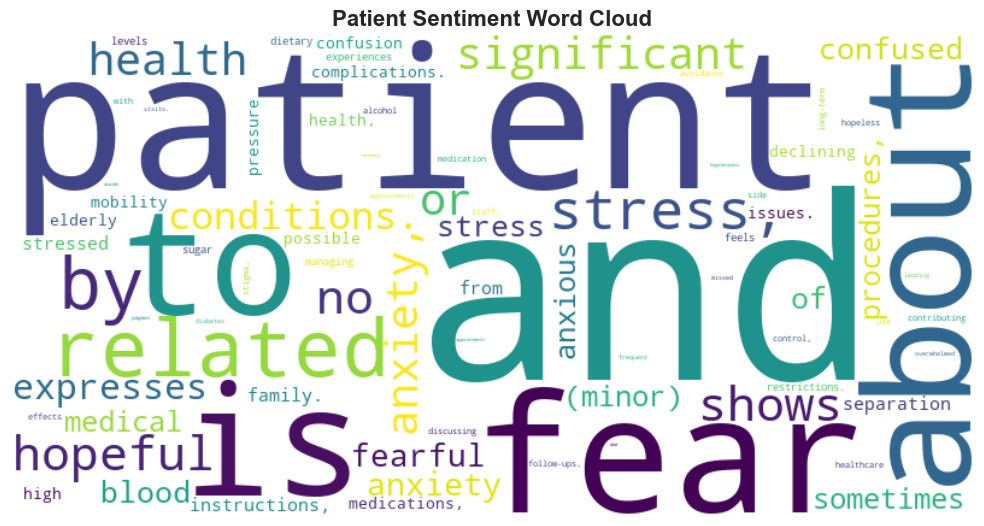

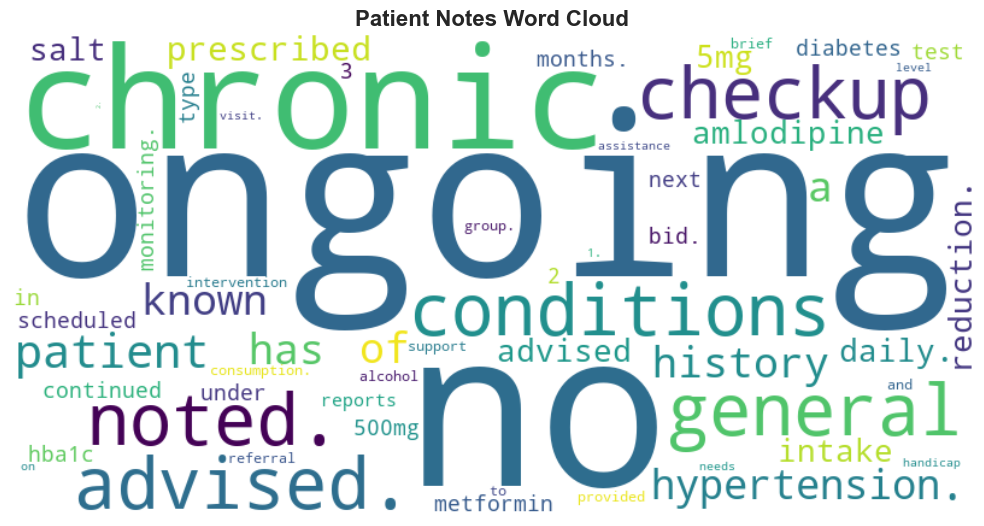

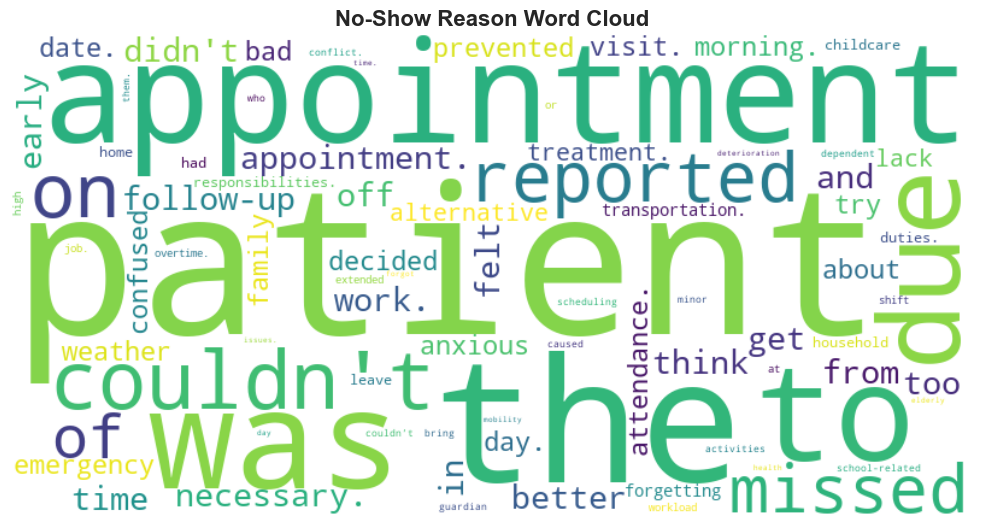

In [6]:
# Plot emotional states as a bar plot - Using class method
plotter.plot_emotional_states_bar(df)

# Plot word clouds for PatientSentiment, PatientNotes, and NoShowReason
plotter.plot_text_wordcloud(df['PatientSentiment'], title='Patient Sentiment Word Cloud')
plotter.plot_text_wordcloud(df['PatientNotes'], title='Patient Notes Word Cloud')
plotter.plot_text_wordcloud(df['NoShowReason'], title='No-Show Reason Word Cloud')

# Supervised Learning for Patient Show/No Show Prediction

Implement supervised learning algorithms to predict patient show/no-show.

# Unsupervised Learning

Apply unsupervised learning techniques to cluster patients.

## Unsupervised Learning Conclusion

K-Means and GMM clustering provided insights into patient groupings.

# NLP Analysis on Patient Appointments

Perform NLP analysis on patient notes and sentiments.

1. Patient Sentiment Analysis - TinyBert
1. Patient Notes Analysis -  ClinicalBERT
1. No Show Reason Analysis - DistillBERT

# Patient Sentiment Analysis (TinyBERT)

This section analyzes patient sentiments using a TinyBERT-based transformer model, with emotion and negation handling. The approach is optimized for CPU and reuses project configuration and CSVs.

In [7]:
# Instantiate the sentiment analysis model
sa_model = SentimentAnalysisModel(df, emotional_states=EMOTION_STATES, device=NLP_CONFIG['device'])

# Train the model
sa_model.train()

# Evaluate the model
predictions, actual_labels = sa_model.evaluate()

# Get metrics
sentiment_analysis_metrics = sa_model.report(predictions, actual_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2


Validating: 100%|██████████| 415/415 [00:19<00:00, 21.73it/s]


Epoch 1: Train Loss: 0.2282, Val Loss: 0.1066
Epoch 2/2


Validating: 100%|██████████| 415/415 [00:20<00:00, 20.09it/s]


Epoch 2: Train Loss: 0.0842, Val Loss: 0.0747
Training completed in 846.10 seconds


Evaluating: 100%|██████████| 691/691 [00:38<00:00, 18.14it/s]



Model Accuracy by Emotion:
  anxiety: 1.0000
  stress: 0.9888
  confusion: 0.9836
  hopeful: 1.0000
  fear: 0.9977

Overall Accuracy: 0.9940

Classification Reports:

Anxiety:
  Not Present: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7252.0}
  Present: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14854.0}
  macro avg: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22106.0}
  weighted avg: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22106.0}

Stress:
  Not Present: {'precision': 1.0, 'recall': 0.8233618233618234, 'f1-score': 0.903125, 'support': 1404.0}
  Present: {'precision': 0.9881622911694511, 'recall': 1.0, 'f1-score': 0.9940459041582637, 'support': 20702.0}
  macro avg: {'precision': 0.9940811455847256, 'recall': 0.9116809116809117, 'f1-score': 0.9485854520791318, 'support': 22106.0}
  weighted avg: {'precision': 0.9889141297290318, 'recall': 0.9887813263367412, 'f1-score': 0.9882713203602811, 'support': 22106.0}

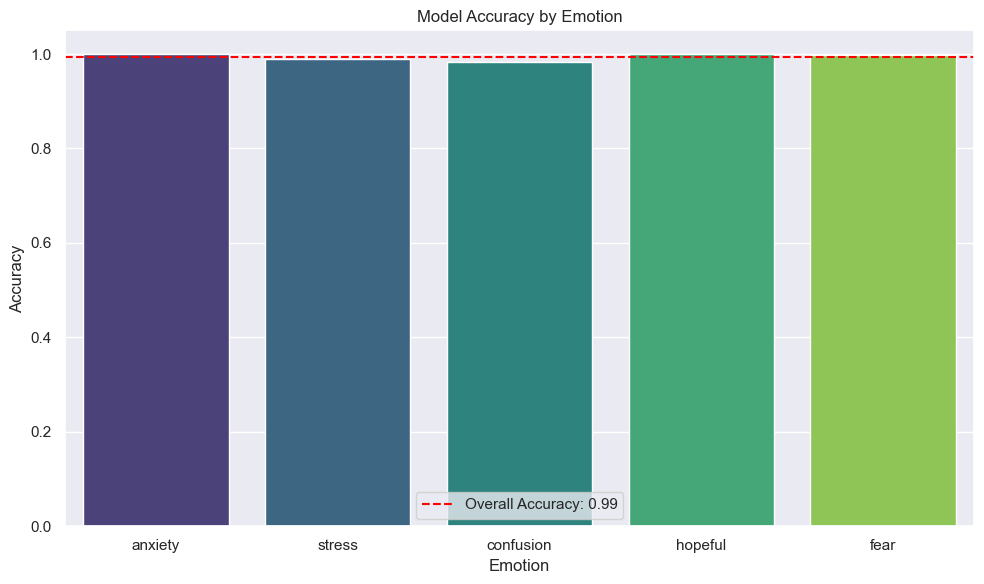

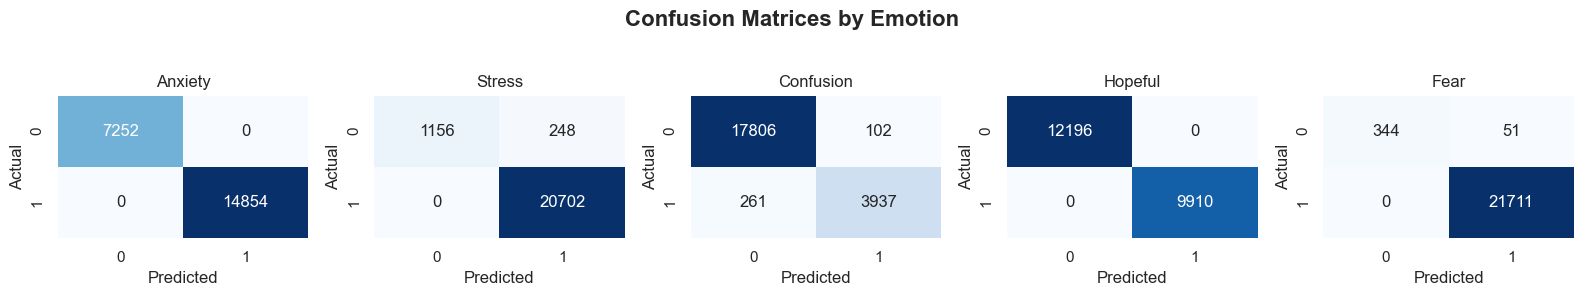

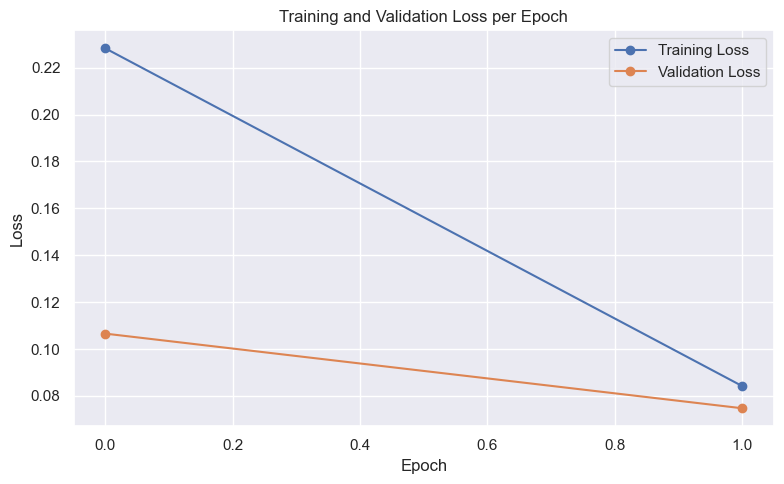

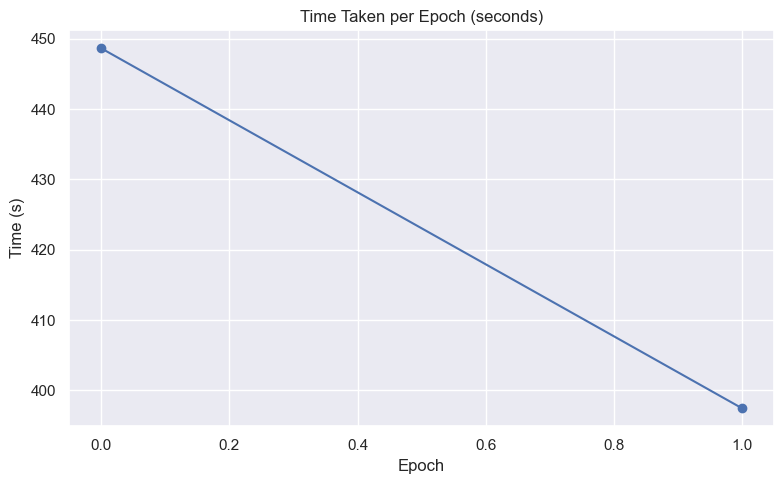

In [8]:
# Print metrics in a readable format
plotter.print_sentiment_metrics(sentiment_analysis_metrics)

# Plot accuracy by emotion with overall accuracy line
plotter.plot_accuracy_by_emotion(sentiment_analysis_metrics)

# Plot confusion matrices for each emotion
plotter.plot_confusion_matrices(actual_labels, predictions, sa_model.emotional_states)

# Plot training and validation loss
sa_stats = sa_model.get_training_stats()
plotter.plot_training_validation_loss(sa_stats['training_losses'], sa_stats['validation_losses'])

# Plot time taken per epoch
plotter.plot_epoch_times(sa_stats['epoch_times'])



--- Hyperparameter Configuration 1/2 ---
Learning Rate: 5e-05
Batch Size: 16
Max Epochs: 2
Early Stopping Patience: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating Epoch 1: 100%|██████████| 415/415 [00:15<00:00, 26.15it/s]


Epoch 1: Train Loss: 0.2468, Val Loss: 0.0003


Validating Epoch 2: 100%|██████████| 415/415 [00:13<00:00, 30.62it/s]


Epoch 2: Train Loss: 0.1587, Val Loss: 0.0003
Early stopping counter: 1/1
Early stopping triggered after 2 epochs


Evaluating: 100%|██████████| 691/691 [00:22<00:00, 30.90it/s]



Overall Accuracy: 0.9941
Training Time: 704.28 seconds

--- Hyperparameter Configuration 2/2 ---
Learning Rate: 0.0001
Batch Size: 16
Max Epochs: 2
Early Stopping Patience: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating Epoch 1: 100%|██████████| 415/415 [00:14<00:00, 29.38it/s]


Epoch 1: Train Loss: 0.1522, Val Loss: 0.0002


Validating Epoch 2: 100%|██████████| 415/415 [00:18<00:00, 22.82it/s]


Epoch 2: Train Loss: 0.0749, Val Loss: 0.0002
Early stopping counter: 1/1
Early stopping triggered after 2 epochs


Evaluating: 100%|██████████| 691/691 [00:24<00:00, 28.67it/s]



Overall Accuracy: 0.9941
Training Time: 657.77 seconds

--- Results for Hyperparameter Configuration 1 ---
Model Accuracy by Emotion:
  anxiety: 1.0000
  stress: 0.9882
  confusion: 0.9843
  hopeful: 1.0000
  fear: 0.9981

Overall Accuracy: 0.9941

Classification Reports:


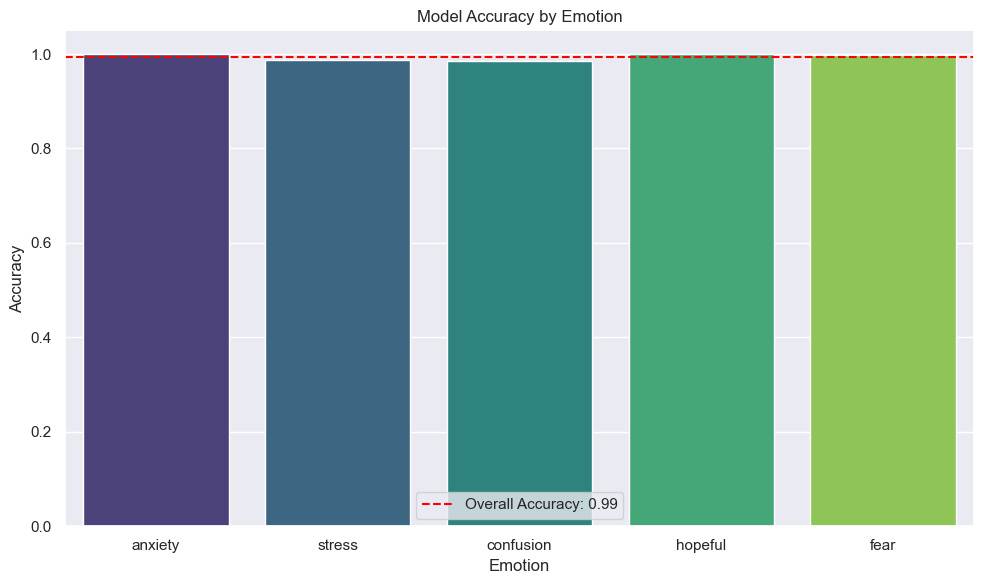

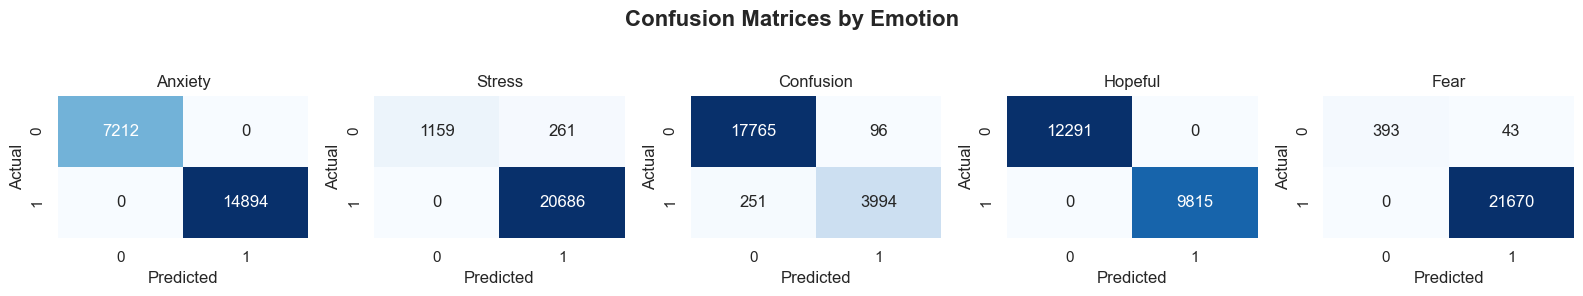

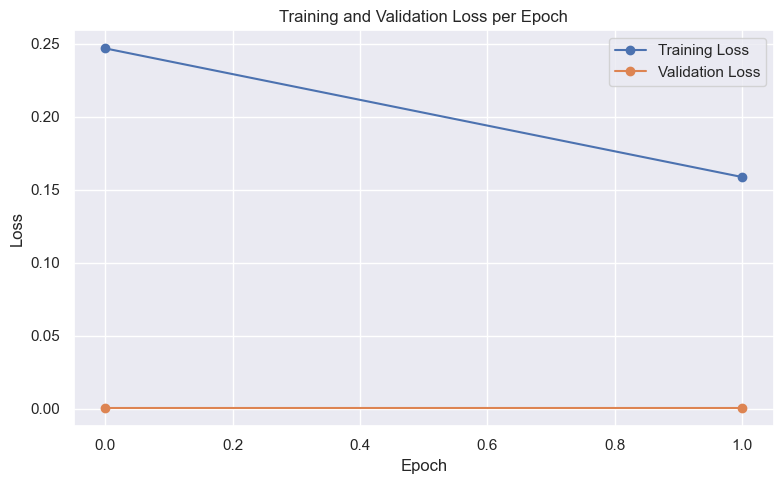

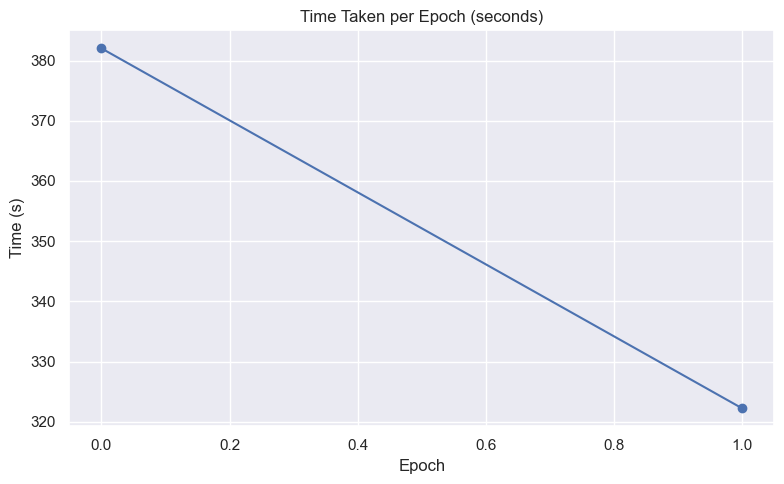


--- Results for Hyperparameter Configuration 2 ---
Model Accuracy by Emotion:
  anxiety: 1.0000
  stress: 0.9882
  confusion: 0.9843
  hopeful: 1.0000
  fear: 0.9981

Overall Accuracy: 0.9941

Classification Reports:


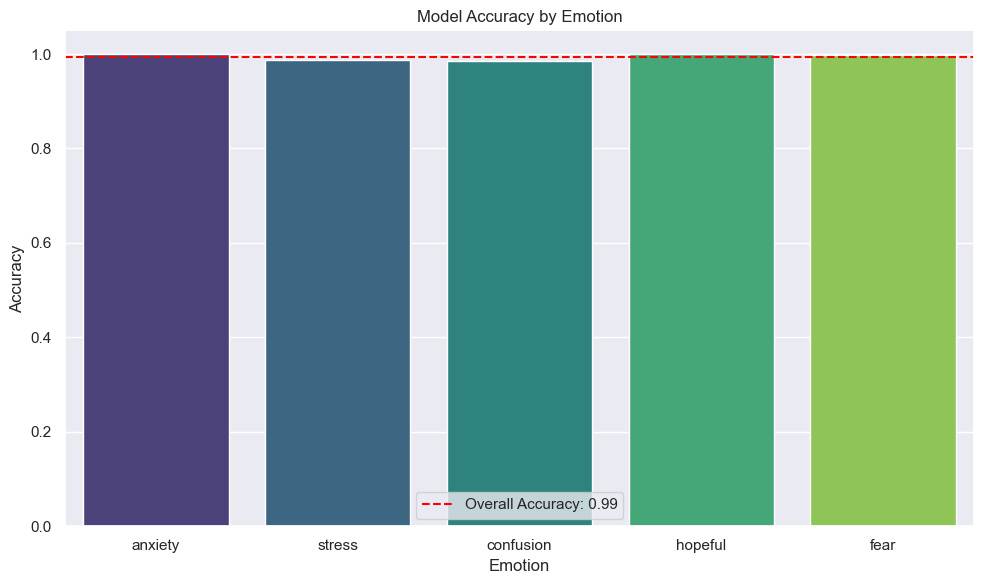

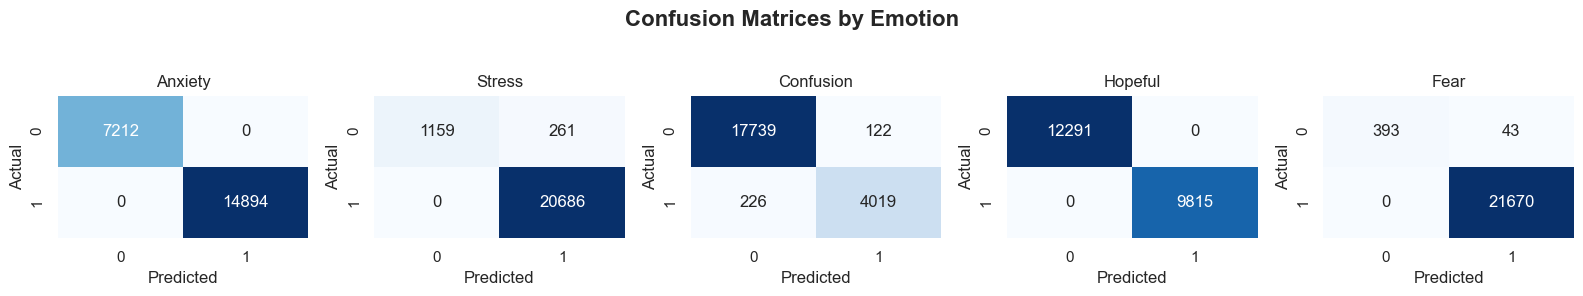

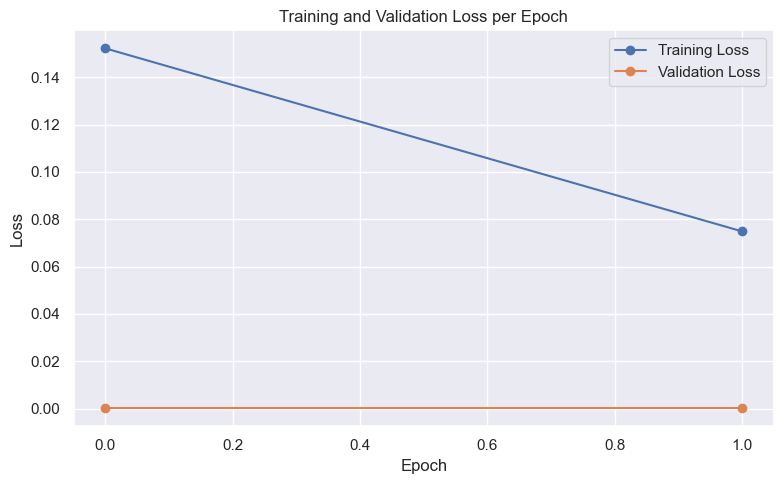

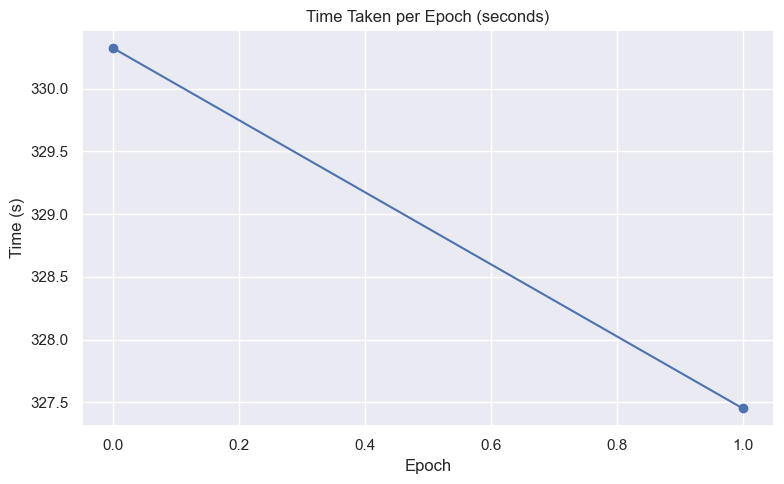

In [9]:
# Prepare data splits for hyperparameter tuning
X = df['PatientSentiment'].values
y = df[EMOTION_STATES].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=NLP_CONFIG['epochs'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=NLP_CONFIG['epochs'])

# Run hyperparameter tuning using the class method
results = SentimentAnalysisModel.run_hyperparameter_tuning(
    X_train, y_train, X_val, y_val, X_test, y_test,
    emotional_states=EMOTION_STATES,
    device=NLP_CONFIG['device'],
    tokenizer=sa_model.tokenizer,
    max_seq_length=NLP_CONFIG['max_length']
)

# Print and plot metrics for each configuration
for i, res in enumerate(results):
    print(f"\n--- Results for Hyperparameter Configuration {i+1} ---")
    # Compute metrics for each configuration
    emotion_accuracies = {emo: accuracy_score(res['actual_labels'][:, idx], res['predictions'][:, idx]) for idx, emo in enumerate(EMOTION_STATES)}
    sentiment_analysis_metrics = {
        'emotion_accuracies': emotion_accuracies,
        'overall_accuracy': res['accuracy'],
        'classification_reports': {}  # Optionally fill with classification_report if needed
    }
    plotter.print_sentiment_metrics(sentiment_analysis_metrics)
    plotter.plot_accuracy_by_emotion(sentiment_analysis_metrics)
    plotter.plot_confusion_matrices(res['actual_labels'], res['predictions'], EMOTION_STATES)
    plotter.plot_training_validation_loss(res['train_losses'], res['val_losses'])
    plotter.plot_epoch_times(res['epoch_times'])



Best model configuration (balanced for both accuracy and speed):
Learning Rate: 0.0001
Batch Size: 16
Epochs: 2
Accuracy: 0.9941
Training Time: 657.77 seconds
Combined Score: 0.9959


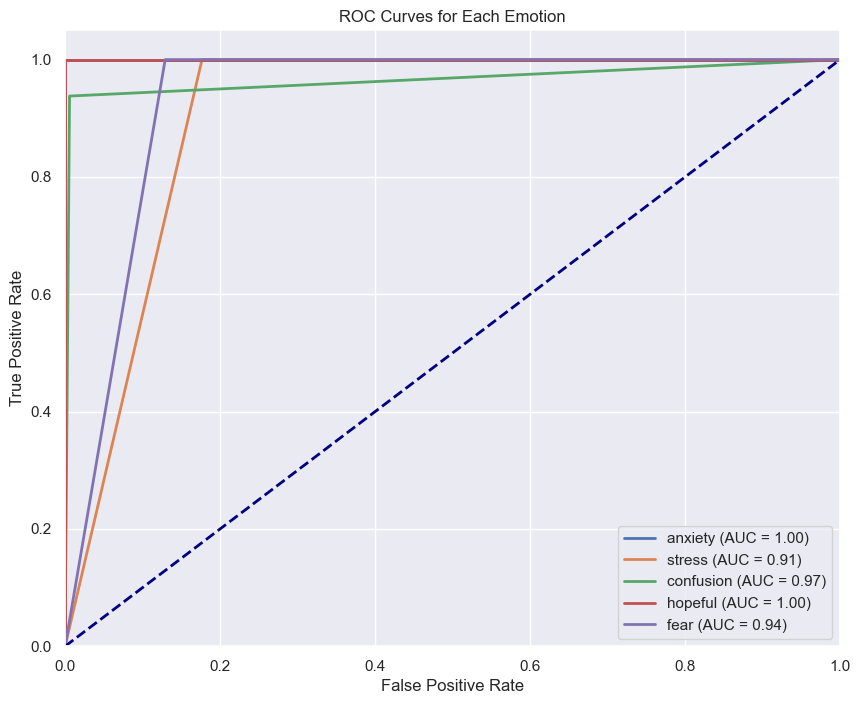

In [10]:
# Select the best model based on accuracy and training time using the class method
best_model, best_params, best_idx, combined_scores = SentimentAnalysisModel.get_best_model_from_results(results)

print(f"\nBest model configuration (balanced for both accuracy and speed):")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Accuracy: {results[best_idx]['accuracy']:.4f}")
print(f"Training Time: {results[best_idx].get('training_time', sum(results[best_idx]['epoch_times'])):.2f} seconds")
print(f"Combined Score: {combined_scores[best_idx]:.4f}")

# Plot ROC and AUC for each emotion using the class-based plotter
plotter.plot_roc_auc_by_emotion(actual_labels, predictions, EMOTION_STATES)


# Run Sentiment Model Unit Tests

Validate the sentiment model's predictions on example texts using the provided unit test. This ensures the model is working as expected and all expected emotions are being detected.

In [46]:
# Export the best model and tokenizer after hyperparameter tuning
SentimentAnalysisModel.export_best_model(
    best_model,
    sa_model.tokenizer,
    SENTIMENT_MODEL_EXPORT_PATH_RAW
)

Best model and tokenizer exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\sentiment_analysis_raw


In [64]:
example_text = "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
expected = {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}

raw_pred = SentimentAnalysisModel.predict_emotions_raw(
    example_text,
    sa_model.model,
    sa_model.tokenizer,
    NLP_CONFIG['device']
)

print("Example text:")
print(example_text)
print("\nEmotion prediction comparison:")
for emo in expected:
    result = "✅" if raw_pred[emo] == expected[emo] else "❌"
    print(f"{emo}: expected={expected[emo]}, predicted={raw_pred[emo]} {result}")

Example text:
Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.

Emotion prediction comparison:
anxiety: expected=True, predicted=False ❌
stress: expected=True, predicted=True ✅
confusion: expected=True, predicted=False ❌
hopeful: expected=False, predicted=False ✅
fear: expected=True, predicted=True ✅


In [73]:
# Run the raw model test
!pytest -s ../tests/test_sentiment_prediction.py -k test_sentiment_model_predictions_raw --maxfail=1 --disable-warnings -q


--- Running test_sentiment_model_predictions_raw ---
✅ Test PASSED for: Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.
Prediction: {'anxiety': 1, 'stress': 1, 'confusion': 0, 'hopeful': 1, 'fear': 1}
Expected: ['hopeful']

✅ Test PASSED for: Patient expresses fear and anxiety about high blood pressure and possible complications.
Prediction: {'anxiety': 1, 'stress': 0, 'confusion': 0, 'hopeful': 0, 'fear': 1}
Expected: ['fear', 'anxiety']

✅ Test PASSED for: Elderly patient expresses fear of declining health, confusion about medications, and stress related to mobility issues.
Prediction: {'anxiety': 0, 'stress': 1, 'confusion': 1, 'hopeful': 0, 'fear': 1}
Expected: ['fear', 'confusion', 'stress']

❌ Test FAILED for: Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.
Prediction: {'anxiety': 0, 'stress': 1, 'confusion': 0, 'hopeful': 0, 'fear': 1}


# Post-Processing with EmotionPostProcessor and Model Evaluation

Use the EmotionPostProcessor and the new SentimentAnalysisModel static methods to predict and evaluate emotions with post-processing.

In [66]:
example_text = "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
expected = {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}

post_processed = SentimentAnalysisModel.predict_emotions(
    example_text,
    sa_model.model,
    sa_model.tokenizer,
    NLP_CONFIG['device'],
    emotion_variations_path=EMOTION_VARIATIONS_PATH,
    negation_patterns_path=NEGATION_PATTERNS_PATH
)
print("Post-processed emotion prediction:", post_processed)
print("Example text:")
print(example_text)
print("\nEmotion prediction comparison:")
for emo in expected:
    result = "✅" if post_processed[emo] == expected[emo] else "❌"
    print(f"{emo}: expected={expected[emo]}, predicted={post_processed[emo]} {result}")

Post-processed emotion prediction: {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}
Example text:
Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.

Emotion prediction comparison:
anxiety: expected=True, predicted=True ✅
stress: expected=True, predicted=True ✅
confusion: expected=True, predicted=True ✅
hopeful: expected=False, predicted=False ✅
fear: expected=True, predicted=True ✅


In [67]:
# Evaluate the model with post-processing on the test set
results_post = SentimentAnalysisModel.evaluate_model_with_post_processing(
    sa_model.model,
    sa_model.test_loader,
    sa_model.tokenizer,
    NLP_CONFIG['device'],
    emotion_variations_path=NLP_CONFIG.get('emotion_variations_path', '../data/emotion_variations.csv'),
    negation_patterns_path=NLP_CONFIG.get('negation_patterns_path', '../data/negation_patterns.csv')
)
print("\nPost-processing overall accuracy:", results_post['accuracy'])
print("Emotion-wise accuracies:", results_post['emotion_accuracies'])

Evaluating with Post-Processing: 100%|██████████| 691/691 [02:46<00:00,  4.16it/s]


Post-processing overall accuracy: 0.6223830634216955
Emotion-wise accuracies: {'anxiety': 0.3032660816068036, 'stress': 0.5517054193431647, 'confusion': 0.742739527730028, 'hopeful': 0.9624988690853162, 'fear': 0.5517054193431647}


# Rerun Unit Tests for Sentiment Model

After post-processing and evaluation, rerun the unit tests to ensure everything is working as expected.

In [70]:
# Export the optimized model and tokenizer with post-processor config
os.makedirs(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, exist_ok=True)
shutil.copy(EMOTION_VARIATIONS_PATH, os.path.join(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, os.path.basename(EMOTION_VARIATIONS_PATH)))
shutil.copy(NEGATION_PATTERNS_PATH, os.path.join(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, os.path.basename(NEGATION_PATTERNS_PATH)))
SentimentAnalysisModel.export_best_model(
    best_model,
    sa_model.tokenizer,
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED
)
print(f"Optimized model and post-processor config exported to: {SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED}")

Best model and tokenizer exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\sentiment_analysis_optimized
Optimized model and post-processor config exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\sentiment_analysis_optimized


In [74]:
# Run the optimized model test
!pytest -s ../tests/test_sentiment_prediction.py -k test_sentiment_model_predictions_optimized  --maxfail=1 --disable-warnings -q


--- Running test_sentiment_model_predictions_optimized ---
✅ Test PASSED for: Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.
Prediction: {'anxiety': 0, 'stress': 0, 'confusion': 0, 'hopeful': 1, 'fear': 0}
Expected: ['hopeful']

✅ Test PASSED for: Patient expresses fear and anxiety about high blood pressure and possible complications.
Prediction: {'anxiety': 1, 'stress': 0, 'confusion': 0, 'hopeful': 0, 'fear': 1}
Expected: ['fear', 'anxiety']

✅ Test PASSED for: Elderly patient expresses fear of declining health, confusion about medications, and stress related to mobility issues.
Prediction: {'anxiety': 0, 'stress': 1, 'confusion': 1, 'hopeful': 0, 'fear': 1}
Expected: ['fear', 'confusion', 'stress']

✅ Test PASSED for: Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.
Prediction: {'anxiety': 1, 'stress': 1, 'confusion': 1, 'hopeful': 0, 'fear